<a href="https://colab.research.google.com/github/DanIulian/BookStore/blob/master/02_rainbow(1)(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Not Quite Rainbow

In [0]:
# !apt install xvfb python-opengl ffmpeg -y > /dev/null 2>&1
# !pip install pyvirtualdisplay > /dev/null 2>&1
# !pip install -U torch > /dev/null 2>&1
# !pip install git+git://github.com/maximecb/gym-minigrid.git@master#egg=gym-minigrid > /dev/null 2>&1

!pip uninstall gym-minigrid gym
!pip install git+git://github.com/floringogianu/gym-minigrid.git@poli#egg=gym-minigrid > /dev/null 2>&1
print("\nRuntime > Restart Runtime after this cell executes!")

Uninstalling gym-0.10.11:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/gym-0.10.11.dist-info/*
    /usr/local/lib/python3.6/dist-packages/gym/*
Proceed (y/n)? y
  Successfully uninstalled gym-0.10.11

Runtime > Restart Runtime after this cell executes!


In [0]:
import itertools
import random
from argparse import Namespace
from collections import deque, defaultdict
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as O
from torchvision import transforms as T
from PIL import Image
import gym
import gym_minigrid
from gym_minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, ReseedWrapper

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"OpenAI Gym: {gym.__version__}. \t\tShould be: ~0.15.x")
print(f"PyTorch   : {torch.__version__}.  \tShould be: >=1.2.x+cu100")
print(f"DEVICE    : {DEVICE}. \t\tShould be: cuda")

OpenAI Gym: 0.15.3. 		Should be: ~0.15.x
PyTorch   : 1.3.0+cu100.  	Should be: >=1.2.x+cu100
DEVICE    : cuda. 		Should be: cuda


In [0]:
def reset_rng(seed=42):
    print(f"Setting all rngs to seed={seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

reset_rng()

Setting all rngs to seed=42


In [0]:
envs = Namespace(
    easy="MiniGrid-Empty-5x5-v0",
    maze="MiniGrid-SimpleCrossingS9N1-v0",
    two_maze="MiniGrid-SimpleCrossingS9N2-v0",
    large_maze="MiniGrid-SimpleCrossingS11N1-v0",
    overestimation="MiniGrid-OverEstimation-9x9-v0",
    random_overestimation="MiniGrid-OverEstimation-Random-9x9-v0",
    fetch="MiniGrid-Fetch-8x8-N3-v0"
)

In [0]:
# Define some helpers: Gym Wrappers and visualization functions

class TorchWrapper(gym.ObservationWrapper):
    """ Applies a couple of transformations depending on the mode.
        Receives numpy arrays and returns torch tensors.
    """

    def __init__(self, env):
        super().__init__(env)
        self._transform = T.Compose([
            lambda obs: (obs * int(255 / 9)).swapaxes(1, 0),
            lambda obs: torch.from_numpy(obs).permute(2, 1, 0)
        ])
    
    def observation(self, obs):
        return self._transform(obs).unsqueeze(0).to(DEVICE)


class FrameStack(gym.Wrapper):
    """Stack k last frames. """

    def __init__(self, env, k, verbose=False):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)

    def reset(self):
        observation = self.env.reset()
        for _ in range(self.k):
            self.frames.append(observation)
        return self._get_ob()

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.frames.append(observation)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        if self.k == 1:
            return self.frames.pop()
        return np.concatenate(list(self.frames), axis=2)


def show_representations(env_name="MiniGrid-SimpleCrossingS9N1-v0", tile_size=8):
    seed = torch.randint(100, (1,)).item()

    env = ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_name), tile_size=tile_size))
    print("Action-space: ", env.action_space.n)
    env.seed(seed)
    rgb_obs = env.reset()

    env = ImgObsWrapper(gym.make(env_name))
    env.seed(seed)
    sym_obs = env.reset()

    print("RGB:", rgb_obs.shape)
    print("SYM:", sym_obs.shape)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 36))
    ax1.imshow(rgb_obs)
    ax2.imshow((sym_obs * int(255 / 9)).swapaxes(1, 0))
    ax3.imshow(env.render(mode="rgb_array"))


def plot_stats(stats, y="ep_rewards", hue=None, window=10):
    df = pd.DataFrame(stats)

    if window:
        new_col = f"avg_{y}"
        if hue is not None:
            df[new_col] = df.groupby(hue)[y].rolling(window=window).mean().reset_index(0,drop=True)
        else:
            df[new_col] = df[y].rolling(window=window).mean()
    
    y = f"avg_{y}" if window else y
    with matplotlib.rc_context({'figure.figsize':(10, 6)}):
        sns.lineplot(x="step_idx", y=y, hue=hue, data=df)

## Let's take a look at the environments

In [0]:
for k, v in vars(envs).items():
    print(f"{k:<24}: {v}")

easy                    : MiniGrid-Empty-5x5-v0
maze                    : MiniGrid-SimpleCrossingS9N1-v0
two_maze                : MiniGrid-SimpleCrossingS9N2-v0
large_maze              : MiniGrid-SimpleCrossingS11N1-v0
overestimation          : MiniGrid-OverEstimation-9x9-v0
random_overestimation   : MiniGrid-OverEstimation-Random-9x9-v0
fetch                   : MiniGrid-Fetch-8x8-N3-v0


Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)


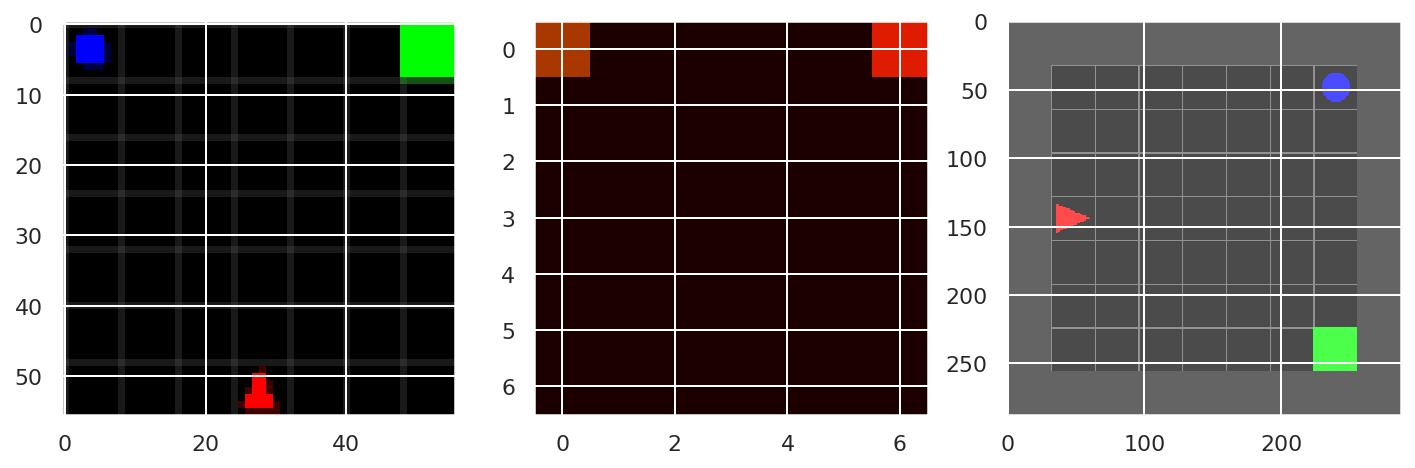

In [0]:
# you can execute this a few times to get an idea about the two possible
# views of the agent
show_representations(envs.overestimation, tile_size=8)

## Let's define the training routine.

It takes an agent and an environment and implements the action-perception loop.

In [0]:
def train(agent, env, step_num=100_000):
    
    stats, N = {"step_idx": [0], "ep_rewards": [0.0], "ep_steps": [0.0]}, 0

    state, done = env.reset().clone(), False
    for step in range(step_num):

        action = agent.step(state)
        state_, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, state_, done)

        # some envs just update the state and are not returning a new one
        state = state_.clone()

        # stats
        stats["ep_rewards"][N] += reward
        stats["ep_steps"][N] += 1

        if done:
            # episode done, reset env!
            state, done = env.reset().clone(), False
        
            # some more stats
            if N % 10 == 0:
                print("[{0:3d}][{1:6d}], R/ep={2:6.2f}, steps/ep={3:2.0f}.".format(
                    N, step,
                    torch.tensor(stats["ep_rewards"][-10:]).mean().item(),
                    torch.tensor(stats["ep_steps"][-10:]).mean().item(),
                ))

            stats["ep_rewards"].append(0.0)  # reward accumulator for a new episode
            stats["ep_steps"].append(0.0)    # reward accumulator for a new episode
            stats["step_idx"].append(step)
            N += 1

    print("[{0:3d}][{1:6d}], R/ep={2:6.2f}, steps/ep={3:2.0f}.".format(
        N, step, torch.tensor(stats["ep_rewards"][-10:]).mean().item(),
        torch.tensor(stats["ep_steps"][-10:]).mean().item(),
    ))
    stats["agent"] = [agent.__class__.__name__ for _ in range(N+1)]
    return stats

## Start implementing the DQN agent

## 1. Experience Replay

#### TASK 1: implement `sample` method.

In [0]:
class ReplayMemory:
    def __init__(self, size=1000, batch_size=32):
        self._buffer = deque(maxlen=size)
        self._batch_size = batch_size
    
    def push(self, transition):
        self._buffer.append(transition)
    
    def sample(self):
        """ Sample from self._buffer

            Should return a tuple of tensors of size: 
            (
                states:     N * (C*K) * H * W,  (torch.uint8)
                actions:    N * 1, (torch.int64)
                rewards:    N * 1, (torch.float32)
                states_:    N * (C*K) * H * W,  (torch.uint8)
                done:       N * 1, (torch.uint8)
            )

            where N is the batch_size, C is the number of channels = 3 and
            K is the number of stacked states.
        """
        # sample
        
        s_list, a_list, r_list, s_list_, d_list = zip(*random.sample(self._buffer, self._batch_size))
        
        s = torch.cat(s_list).to(DEVICE)
        s_ = torch.cat(s_list_).to(DEVICE)
        a = torch.LongTensor(a_list).unsqueeze(-1).to(DEVICE)
        r = torch.DoubleTensor(r_list).unsqueeze(-1).to(DEVICE)
        d = torch.zeros((self._batch_size, 1), dtype=torch.uint8).to(DEVICE)
        d[np.array(d_list) == True] = 1
     
        return (s, a, r, s_, d)
        

    def __len__(self):
        return len(self._buffer)

## 2. $\epsilon$-greedy schedule.

#### TASK 2: Implement the epsilon-greedy schedule

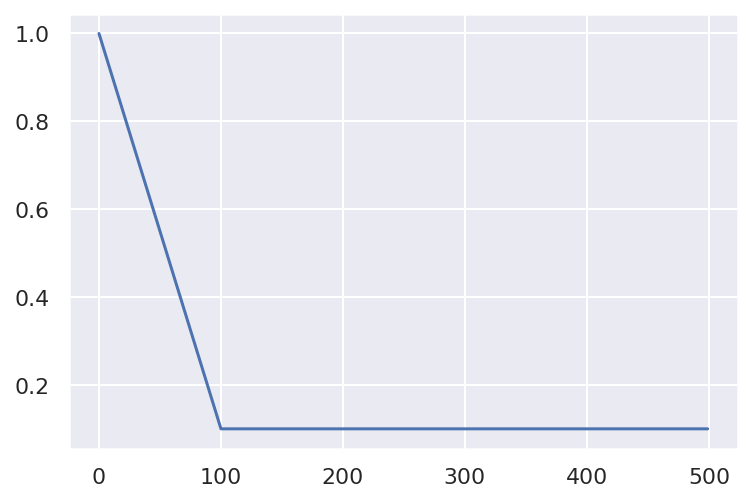

In [0]:
def get_epsilon_schedule(start=1.0, end=0.1, steps=500):
    """ Returns either:
        - a generator of epsilon values
        - a function that receives the current step and returns an epsilon

        The epsilon values returned by the generator or function need
        to be degraded from the `start` value to the `end` within the number 
        of `steps` and then continue returning the `end` value indefinetly.

        You can pick any schedule (exp, poly, etc.). I tested with linear decay.
    """
    t = 0
    while True:
      if t >= steps:
        yield end
      else:
        eps = start - (start - end) / steps * t
        t += 1
        yield eps
        


# test it, it needs to look nice
epsilon = get_epsilon_schedule(1.0, 0.1, 100)
plt.plot([next(epsilon) for _ in range(500)])

# or if you prefer a function
# epsilon_fn = get_epsilon_schedule(1.0, 0.1, 100)
# plt.plot([epsilon(step_idx) for step_idx in range(500)])

### Define a Neural Network Approximator for your Agents

In [0]:
class ByteToFloat(nn.Module):
    """ Converts ByteTensor to FloatTensor and rescales.
    """
    def forward(self, x):
        assert (
            x.dtype == torch.uint8
        ), "The model expects states of type ByteTensor."
        return x.float().div_(255)


class View(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


def get_estimator(action_num, input_ch=3, lin_size=32):
    return nn.Sequential(
        ByteToFloat(),
        nn.Conv2d(input_ch, 16, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=2),
        nn.ReLU(inplace=True),
        View(),
        nn.Linear(9 * 16, lin_size),
        nn.ReLU(inplace=True),
        nn.Linear(lin_size, action_num),
    ).to(DEVICE)

## 3. DQN Agent, finally

#### TASK 3: 
- implement the `step()` method
- implement the `learn()` method
- implement the `_update()` method

In [0]:
class DQN:
    def __init__(
        self,
        estimator,
        buffer,
        optimizer,
        epsilon_schedule,
        action_num,
        gamma=0.92,
        update_steps=4,
        update_target_steps=10,
        warmup_steps=100,
    ):
        self._estimator = estimator
        self._target_estimator = deepcopy(estimator)
        self._buffer = buffer
        self._optimizer = optimizer
        self._epsilon = epsilon_schedule
        self._action_num = action_num
        self._gamma = gamma
        self._update_steps=update_steps
        self._update_target_steps=update_target_steps
        self._warmup_steps = warmup_steps
        self._step_cnt = 0
        assert warmup_steps > self._buffer._batch_size, (
            "You should have at least a batch in the ER.")
    
    def step(self, state):
        # implement an epsilon greedy policy using the
        # estimator and epsilon schedule attributes.

        # warning, you should make sure you are not including
        # this step into torch computation graph
        
        if self._step_cnt < self._warmup_steps:
            return torch.randint(self._action_num, (1,)).item()

        # return the action according to the self._epsilon schedule
        # you defined earlier
        if np.random.random() < next(self._epsilon):
          return torch.randint(self._action_num, (1,)).item()
        else:
          with torch.no_grad():
            acts = self._estimator(state)
            return acts.argmax(dim=1)

          

    def learn(self, state, action, reward, state_, done):

        # TODO: add transition to the experience replay
        self._buffer.push((state, action, reward, state_, done))
        
        if self._step_cnt < self._warmup_steps:
            self._step_cnt += 1
            return

        if self._step_cnt % self._update_steps == 0:
          # TODO: sample from experience replay and do an update
          s, a, r, s_, d = self._buffer.sample() 
          self._update(s, a, r, s_, d)
          
        if self._step_cnt % self._update_target_steps == 0:
           # TODO: update the target estimator (hint, use pytorch state_dict methods)
          self._target_estimator.load_state_dict(self._estimator.state_dict())
           
        self._step_cnt += 1

    def _update(self, states, actions, rewards, states_, done):
        # compute the DeepQNetwork update. Carefull not to include the
        # target network in the computational graph.
         
        # Compute Q(s, * | θ) and Q(s', . | θ^)
        q_values = self._estimator(states)
        
        with torch.no_grad():
          q_values_ = self._target_estimator(states_)
        
        qsa = torch.gather(q_values, dim=1, index=actions)
        qsa_, _ = torch.max(q_values_, dim=1)
        qsa_ = qsa_.unsqueeze(-1)
        # compute Q(s, a) and max_a' Q(s', a')
        # qsa = 
        # qsa_ = 

        
        # compute target values
        target_qsa = rewards + (1 - done) * self._gamma * qsa_

        # at this step you should check the target values
        # are looking about right :). You can use this code.
        # if rewards.squeeze().sum().item() > 0.0:
        #     print("R: ", rewards.squeeze())
        #     print("T: ", target_qsa.squeeze())
        #     print("D: ", done.squeeze())

        # compute the loss and average it over the entire batch
        
        loss =  nn.functional.mse_loss(qsa.float(), target_qsa.float())
        
        self._optimizer.zero_grad()
        loss.backward()

        self._optimizer.step()
        # backprop and optimize
        


In [0]:
env = gym.make(envs.easy)
env = TorchWrapper(ImgObsWrapper(env))
net = get_estimator(env.action_space.n)

stats = train(
    DQN(
        net,
        ReplayMemory(size=1000, batch_size=32),
        O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
        get_epsilon_schedule(start=1.0, end=0.1, steps=4000),
        env.action_space.n,
        warmup_steps=100,
        update_steps=2,
    ),
    env,
    step_num=7_000  # change the experiment length if it's learning but not reaching about .95
)

[  0][    99], R/ep=  0.00, steps/ep=100.
[ 10][   851], R/ep=  0.28, steps/ep=75.
[ 20][  1596], R/ep=  0.29, steps/ep=74.
[ 30][  2156], R/ep=  0.47, steps/ep=56.
[ 40][  2942], R/ep=  0.25, steps/ep=79.
[ 50][  3704], R/ep=  0.26, steps/ep=76.
[ 60][  4590], R/ep=  0.15, steps/ep=89.
[ 70][  4858], R/ep=  0.76, steps/ep=27.
[ 80][  5050], R/ep=  0.83, steps/ep=19.
[ 90][  5125], R/ep=  0.93, steps/ep= 8.
[100][  5234], R/ep=  0.90, steps/ep=11.
[110][  5302], R/ep=  0.94, steps/ep= 7.
[120][  5373], R/ep=  0.94, steps/ep= 7.
[130][  5449], R/ep=  0.93, steps/ep= 8.
[140][  5511], R/ep=  0.94, steps/ep= 6.
[150][  5583], R/ep=  0.94, steps/ep= 7.
[160][  5649], R/ep=  0.94, steps/ep= 7.
[170][  5718], R/ep=  0.94, steps/ep= 7.
[180][  5785], R/ep=  0.94, steps/ep= 7.
[190][  5848], R/ep=  0.94, steps/ep= 6.
[200][  5926], R/ep=  0.93, steps/ep= 8.
[210][  5994], R/ep=  0.94, steps/ep= 7.
[220][  6061], R/ep=  0.94, steps/ep= 7.
[230][  6133], R/ep=  0.94, steps/ep= 7.
[240][  6195], 

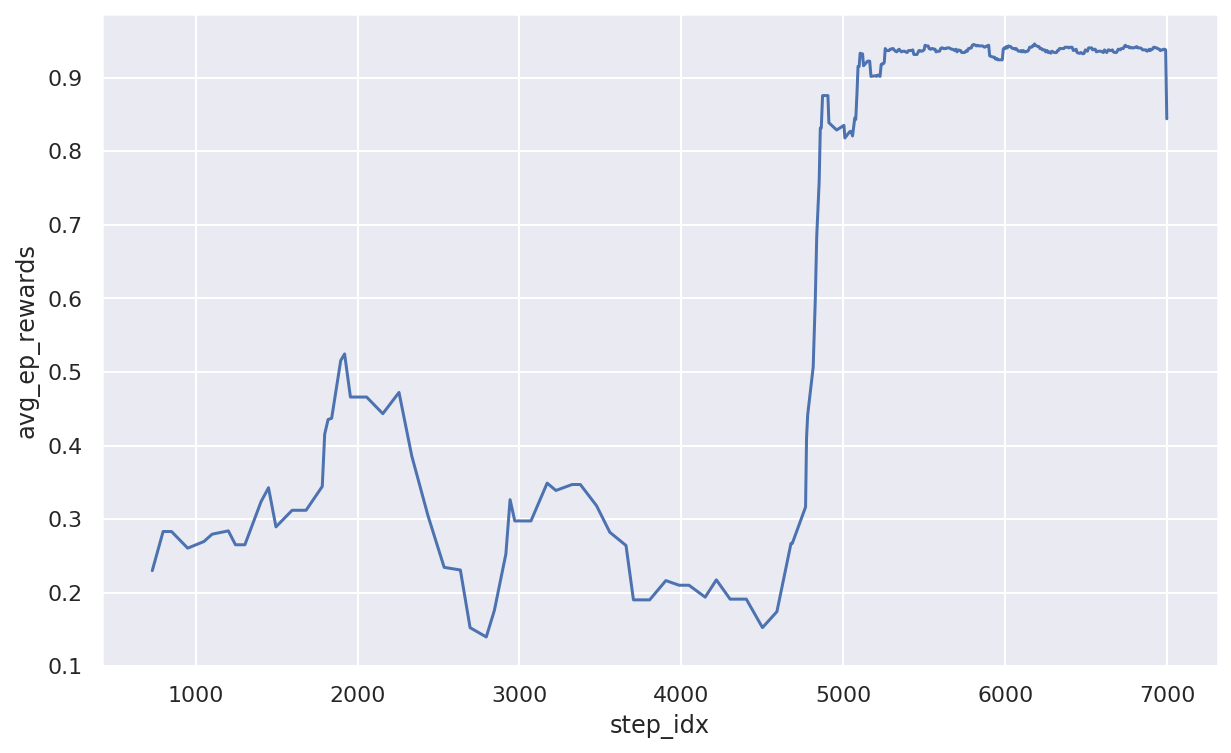

In [0]:
plot_stats(stats)

## 4. Train on a partial observable maze

Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)


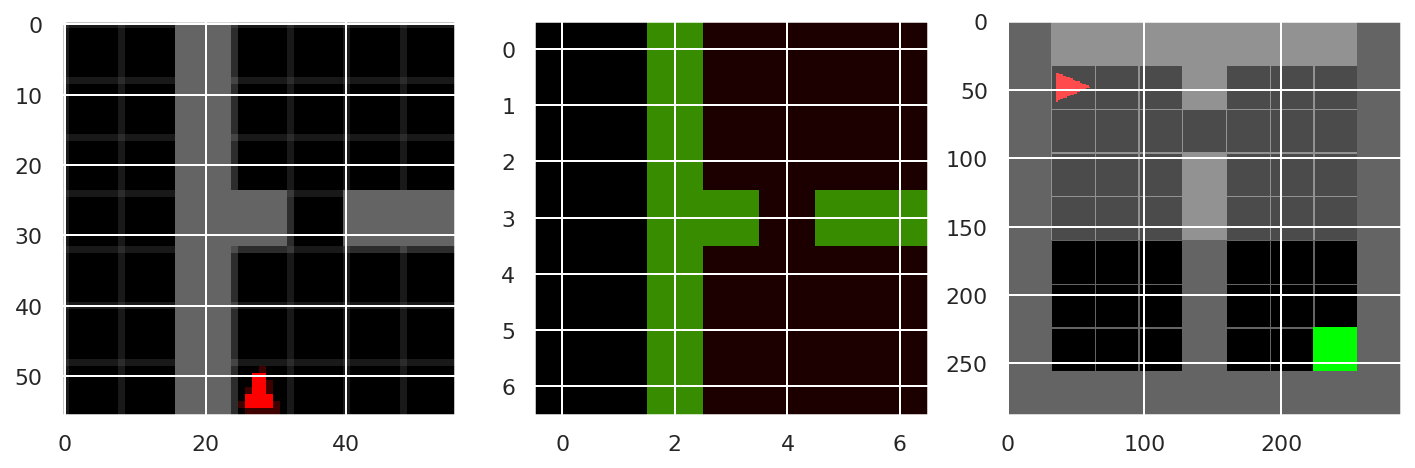

In [0]:
show_representations(envs.maze)
# show_representations(envs.large_maze)

In [0]:
step_num=30_000
seeds = [2, 5]          # add more map configurations
hist_len = [1, 2, 3]    # increase it to two and compare

common_seed = np.random.randint(1000)
stats = defaultdict(list)
for K in hist_len:
    print(f"Started training with hist_len={K}.")
    # 102 worked nicely here :))
    reset_rng(common_seed)  # we want each experiment to have the same starting conditions
 
    env = gym.make(envs.maze)
    env = TorchWrapper(FrameStack(ImgObsWrapper(ReseedWrapper(env, seeds=seeds)), k=K))
    net = get_estimator(env.action_space.n, input_ch=K*3, lin_size=64)
    
    stats_ = train(
        DQN(
            net,
            ReplayMemory(size=10_000, batch_size=32),
            O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
            get_epsilon_schedule(start=1.0, end=0.1, steps=10_000),
            env.action_space.n,
            warmup_steps=1000,
            update_steps=2,
            update_target_steps=8
        ),
        env,
        step_num=step_num
    )

    stats_["hist_len"] = [K] * len(stats_["ep_rewards"])
    for k, v in stats_.items():
        stats[k] += v

Started training with hist_len=1.
Setting all rngs to seed=988
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3432], R/ep=  0.06, steps/ep=311.
[ 20][  6672], R/ep=  0.00, steps/ep=324.
[ 30][  9213], R/ep=  0.24, steps/ep=254.
[ 40][ 12297], R/ep=  0.06, steps/ep=308.
[ 50][ 15499], R/ep=  0.03, steps/ep=320.
[ 60][ 17776], R/ep=  0.33, steps/ep=228.
[ 70][ 20292], R/ep=  0.24, steps/ep=252.
[ 80][ 22879], R/ep=  0.21, steps/ep=259.
[ 90][ 24408], R/ep=  0.55, steps/ep=153.
[100][ 25161], R/ep=  0.79, steps/ep=75.
[110][ 25914], R/ep=  0.78, steps/ep=75.
[120][ 26319], R/ep=  0.89, steps/ep=40.
[130][ 26812], R/ep=  0.86, steps/ep=49.
[140][ 27114], R/ep=  0.92, steps/ep=30.
[150][ 27678], R/ep=  0.84, steps/ep=56.
[160][ 28567], R/ep=  0.73, steps/ep=89.
[170][ 29232], R/ep=  0.82, steps/ep=66.
[180][ 29646], R/ep=  0.89, steps/ep=41.
[190][ 29932], R/ep=  0.92, steps/ep=29.
[191][ 29999], R/ep=  0.83, steps/ep=31.
Started training with hist_len=2.
Setting all rngs to seed=988
[  

KeyboardInterrupt: ignored

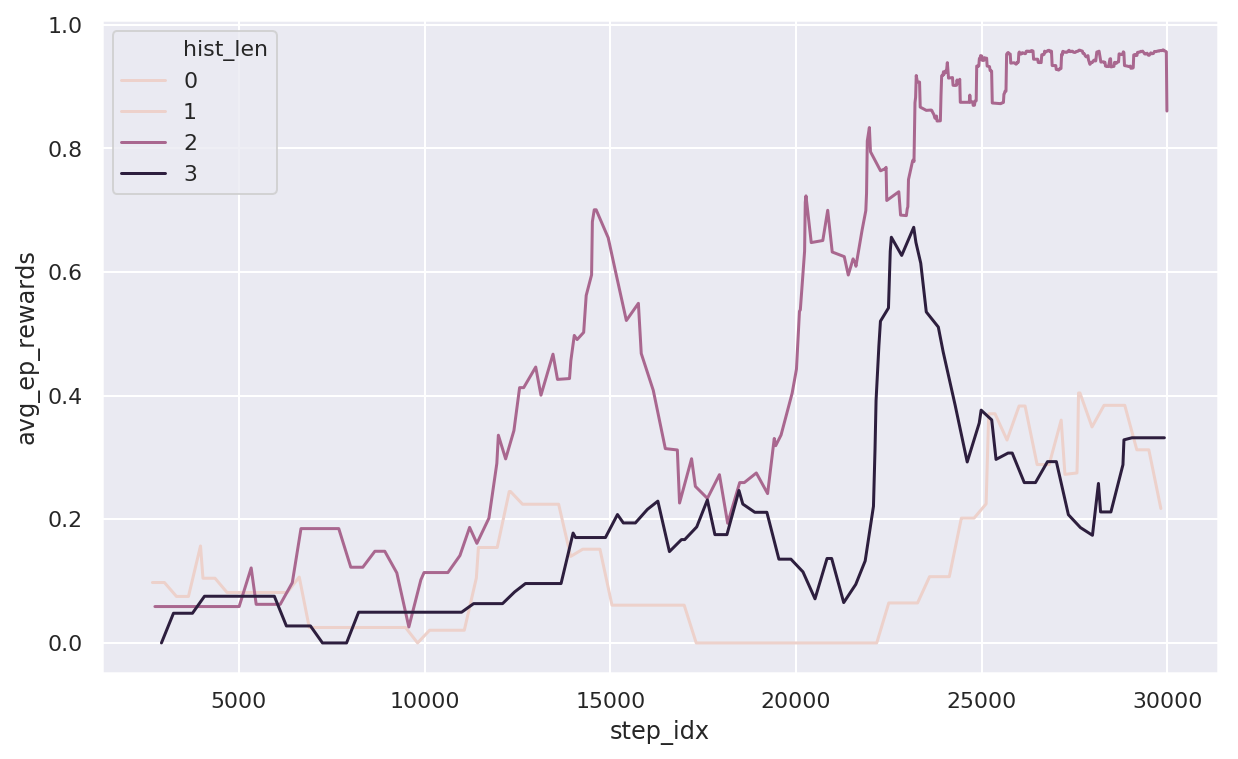

In [0]:
plot_stats(stats, hue="hist_len")

## 5. Double DQN


#### TASK 4: Implement the _update() method for DoubleDQN

In [0]:
class DoubleDQN(DQN):
    def _update(self, states, actions, rewards, states_, done):
        # compute the DeepQNetwork update. Carefull not to include the
        # target network in the computational graph.

        # Compute Q(s, * | θ) and Q(s', . | θ^)
        # q_values = 
        # q_values_ = 
        
        #... and the rest of it

        # Compute Q(s, * | θ) and Q(s', . | θ^)
        
        with torch.no_grad():
          q_values_target = self._target_estimator(states_)
          q_values_doubledqn = self._estimator(states_)
        
        q_values_online_net = self._estimator(states)

        qsa_online_net = torch.gather(q_values_online_net, dim=1, index=actions)
        
        actions_max = torch.argmax(q_values_doubledqn, dim=1).unsqueeze(-1)
        
        qsa_target_net = torch.gather(q_values_target, dim=1, index=actions_max)
        
        #qsa = torch.gather(q_values, dim=1, index=actions)
        #qsa_, _ = torch.max(q_values_, dim=1)
        #qsa_ = qsa_.unsqueeze(-1)
        # compute Q(s, a) and max_a' Q(s', a')
        # qsa = 
        # qsa_ = 

        
        # compute target values
        target_qsa = rewards + (1 - done) * self._gamma * qsa_target_net

        # at this step you should check the target values
        # are looking about right :). You can use this code.
        # if rewards.squeeze().sum().item() > 0.0:
        #     print("R: ", rewards.squeeze())
        #     print("T: ", target_qsa.squeeze())
        #     print("D: ", done.squeeze())

        # compute the loss and average it over the entire batch
        
        loss =  nn.functional.mse_loss(qsa_online_net.float(), target_qsa.float())
        
        self._optimizer.zero_grad()
        loss.backward()

        self._optimizer.step()
        # backprop and optimize

In [0]:
env = gym.make(envs.easy)
env = TorchWrapper(ImgObsWrapper(env))
net = get_estimator(env.action_space.n)

stats = train(
    DoubleDQN(
        net,
        ReplayMemory(size=1000, batch_size=32),
        O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
        get_epsilon_schedule(start=1.0, end=0.1, steps=4000),
        env.action_space.n,
        warmup_steps=100,
        update_steps=2,
        update_target_steps=16
    ),
    env,
    step_num=7_000  # change the experiment length if it's learning but not reaching about .95
)

[  0][    21], R/ep=  0.80, steps/ep=22.
[ 10][   890], R/ep=  0.15, steps/ep=87.
[ 20][  1481], R/ep=  0.45, steps/ep=59.
[ 30][  1967], R/ep=  0.55, steps/ep=49.
[ 40][  2525], R/ep=  0.48, steps/ep=56.
[ 50][  3191], R/ep=  0.37, steps/ep=67.
[ 60][  3835], R/ep=  0.38, steps/ep=64.
[ 70][  4340], R/ep=  0.52, steps/ep=50.
[ 80][  4527], R/ep=  0.83, steps/ep=19.
[ 90][  4690], R/ep=  0.85, steps/ep=16.
[100][  4871], R/ep=  0.84, steps/ep=18.
[110][  4944], R/ep=  0.93, steps/ep= 7.
[120][  5024], R/ep=  0.93, steps/ep= 8.
[130][  5124], R/ep=  0.91, steps/ep=10.
[140][  5257], R/ep=  0.88, steps/ep=13.
[150][  5345], R/ep=  0.92, steps/ep= 9.
[160][  5429], R/ep=  0.92, steps/ep= 8.
[170][  5524], R/ep=  0.91, steps/ep=10.
[180][  5593], R/ep=  0.94, steps/ep= 7.
[190][  5676], R/ep=  0.93, steps/ep= 8.
[200][  5760], R/ep=  0.92, steps/ep= 8.
[210][  5836], R/ep=  0.93, steps/ep= 8.
[220][  5910], R/ep=  0.93, steps/ep= 7.
[230][  5988], R/ep=  0.93, steps/ep= 8.
[240][  6062], R

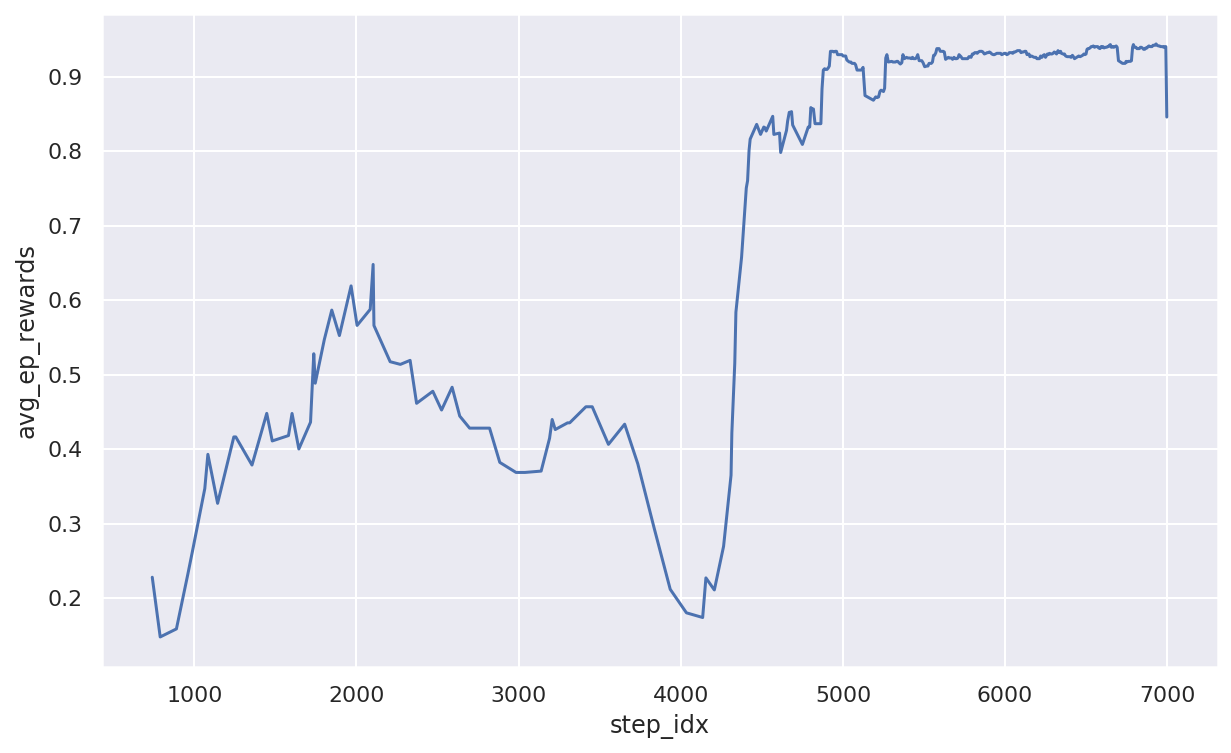

In [0]:
plot_stats(stats)

## 6. DQN vs Double DQN: OverEstimation environment

Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)


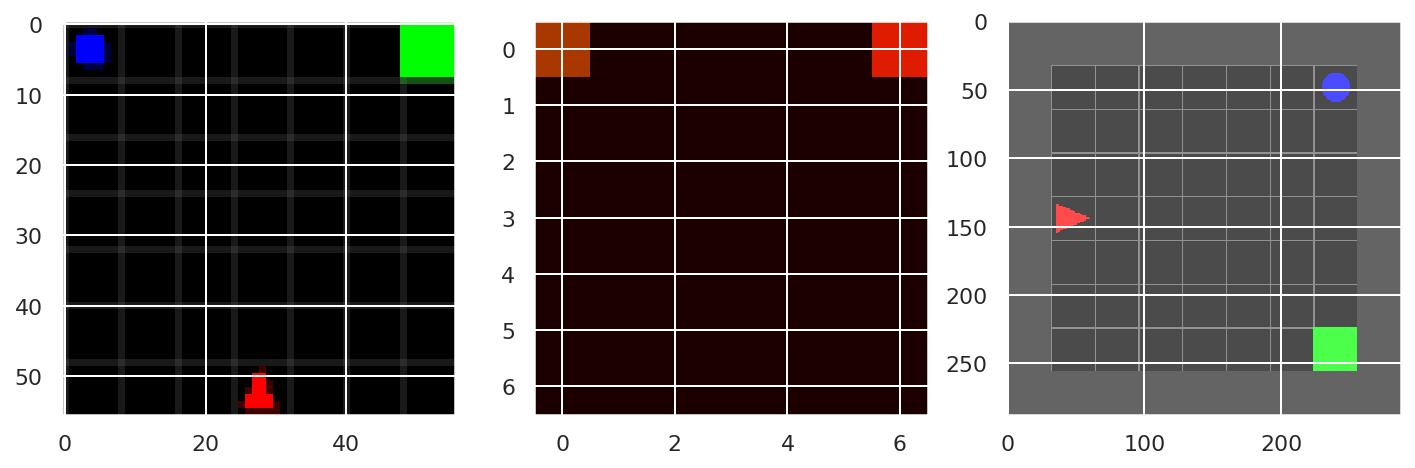

In [0]:
show_representations(envs.overestimation)

In [0]:
step_num = 50_000           # change the experiment length
stats = defaultdict(list)

common_seed = np.random.randint(1000)
for Agent in [DQN, DoubleDQN]:
    # 256 worked nicely here :))
    reset_rng(common_seed)  # we want each experiment to have the same starting conditions

    env = TorchWrapper(ImgObsWrapper(gym.make(envs.overestimation)))
    net = get_estimator(env.action_space.n)
    
    agent_name = Agent.__name__
    print(f"\n{agent_name} started training.")
    stats_ = train(
        Agent(
            net,
            ReplayMemory(size=5000, batch_size=32),
            O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
            get_epsilon_schedule(start=1.0, end=0.1, steps=5000),
            env.action_space.n,
            warmup_steps=3000,
            update_steps=2,
            update_target_steps=256
        ),
        env,
        step_num=step_num
    )

    for k, v in stats_.items():
        stats[k] += v

Setting all rngs to seed=668

DQN started training.
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  2902], R/ep=  0.33, steps/ep=258.
[ 20][  5564], R/ep=  0.49, steps/ep=266.
[ 30][  6351], R/ep=  2.20, steps/ep=79.
[ 40][  7539], R/ep=  0.67, steps/ep=119.
[ 50][  9377], R/ep= -0.38, steps/ep=184.
[ 60][ 12617], R/ep=  0.00, steps/ep=324.
[ 70][ 14374], R/ep=  0.39, steps/ep=176.
[ 80][ 15398], R/ep=  0.35, steps/ep=102.
[ 90][ 15831], R/ep=  0.54, steps/ep=43.
[100][ 16695], R/ep=  1.80, steps/ep=86.
[110][ 17018], R/ep=  1.42, steps/ep=32.
[120][ 17176], R/ep=  0.89, steps/ep=16.
[130][ 17973], R/ep=  1.17, steps/ep=80.
[140][ 20592], R/ep=  0.86, steps/ep=262.
[150][ 21701], R/ep=  0.75, steps/ep=111.
[160][ 22048], R/ep=  1.44, steps/ep=35.
[170][ 22373], R/ep=  1.72, steps/ep=32.
[180][ 22706], R/ep=  0.71, steps/ep=33.
[190][ 22996], R/ep= -0.20, steps/ep=29.
[200][ 23614], R/ep=  0.72, steps/ep=62.
[210][ 23913], R/ep=  1.39, steps/ep=30.
[220][ 24179], R/ep=  0.19, steps/ep

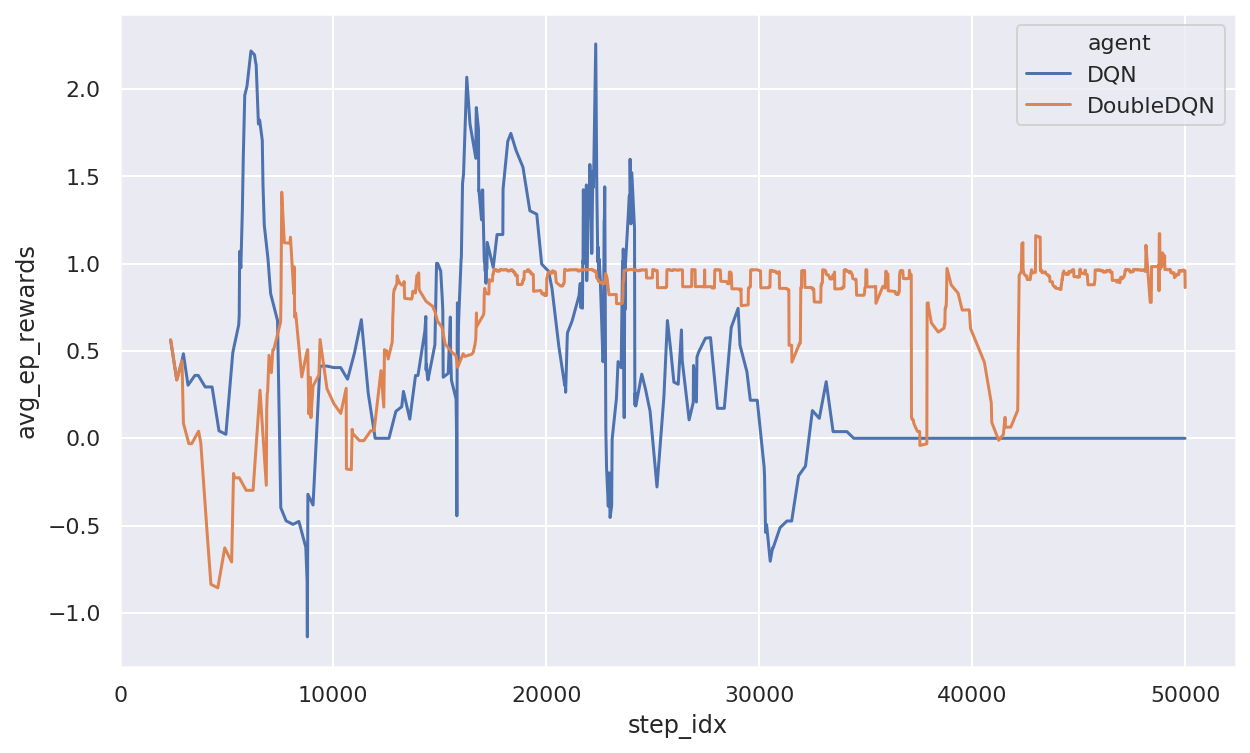

In [0]:
plot_stats(stats, hue="agent")

## 7. DQN vs DoubleDQN: Maze Environment

Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)


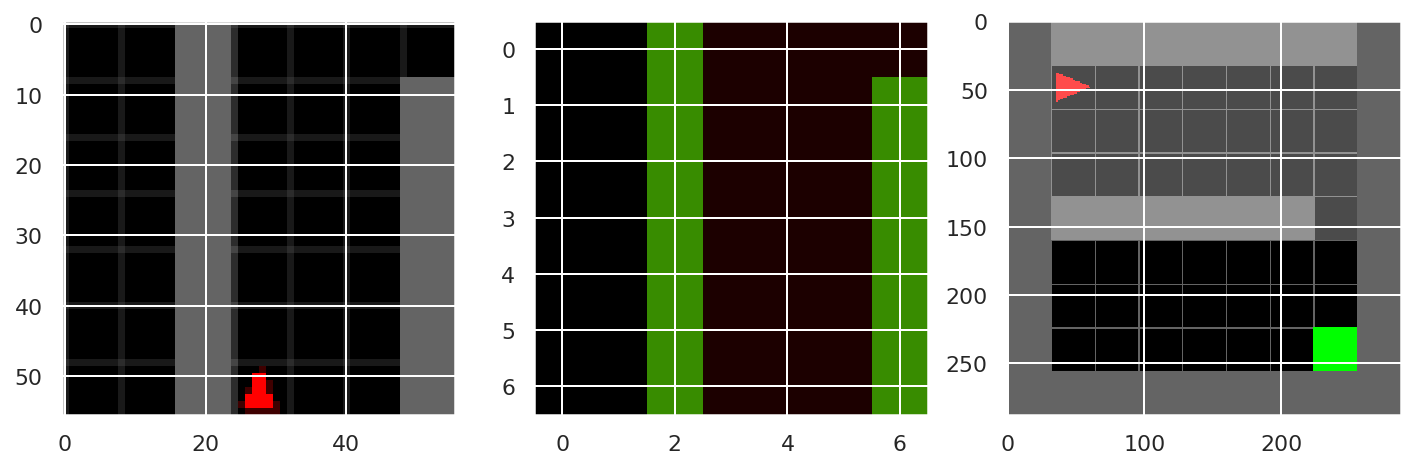

In [0]:
show_representations(envs.maze)

In [0]:
env_name = envs.maze
step_num = 50_000           # change the experiment length
seeds = [2, 5]              # add more maps
K = 2
stats = defaultdict(list)

common_seed = np.random.randint(1000)
for Agent in [DQN, DoubleDQN]:
    # maybe 621? :))
    reset_rng(common_seed)  # we want each experiment to have the same starting conditions

    env = gym.make(env_name)
    env = TorchWrapper(FrameStack(ImgObsWrapper(ReseedWrapper(env, seeds=seeds)), k=K))
    net = get_estimator(env.action_space.n, input_ch=K*3, lin_size=64)
    
    agent_name = Agent.__name__
    print(f"\n{agent_name} started training.")
    stats_ = train(
        Agent(
            net,
            ReplayMemory(size=10_000, batch_size=32),
            O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
            get_epsilon_schedule(start=1.0, end=0.1, steps=10_000),
            env.action_space.n,
            warmup_steps=1000,
            update_steps=2,
            update_target_steps=256
        ),
        env,
        step_num=step_num
    )

    for k, v in stats_.items():
        stats[k] += v

Setting all rngs to seed=526

DQN started training.
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3563], R/ep=  0.00, steps/ep=324.
[ 20][  6668], R/ep=  0.05, steps/ep=310.
[ 30][  9758], R/ep=  0.05, steps/ep=309.
[ 40][ 12998], R/ep=  0.00, steps/ep=324.
[ 50][ 16222], R/ep=  0.01, steps/ep=322.
[ 60][ 19196], R/ep=  0.10, steps/ep=297.
[ 70][ 22362], R/ep=  0.03, steps/ep=317.
[ 80][ 25238], R/ep=  0.13, steps/ep=288.
[ 90][ 28403], R/ep=  0.04, steps/ep=316.
[100][ 31643], R/ep=  0.00, steps/ep=324.
[110][ 34796], R/ep=  0.03, steps/ep=315.
[120][ 37419], R/ep=  0.20, steps/ep=262.
[130][ 39680], R/ep=  0.34, steps/ep=226.
[140][ 40807], R/ep=  0.69, steps/ep=113.
[150][ 42796], R/ep=  0.41, steps/ep=199.
[160][ 46036], R/ep=  0.00, steps/ep=324.
[170][ 48264], R/ep=  0.36, steps/ep=223.
[179][ 49999], R/ep=  0.36, steps/ep=182.
Setting all rngs to seed=526

DoubleDQN started training.
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3501], R/ep=  0.04, steps/ep=318.
[ 20][  

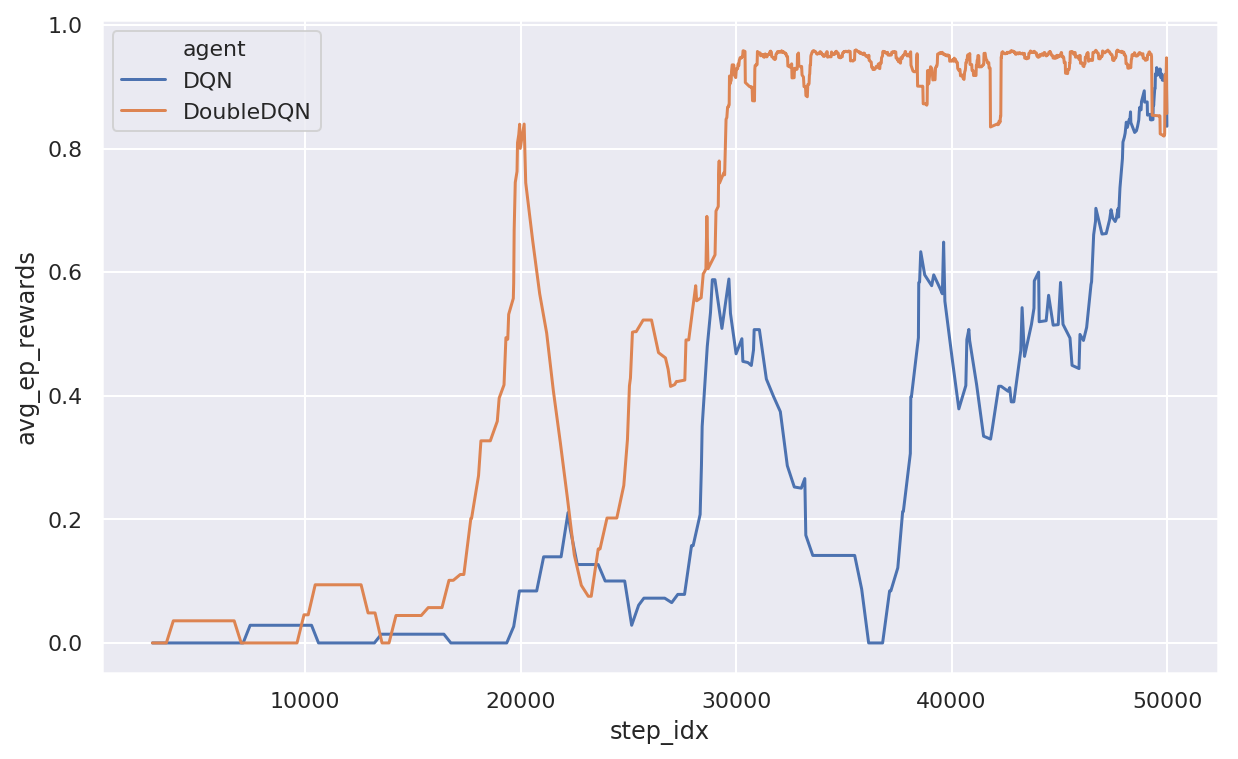

In [0]:
plot_stats(stats, hue="agent")

## 8. Dueling DQN

### BONUS TASK: Implement Dueling DQN and compare it on any env you want with the other two methods.

Extra-credits for showing statistically-relevant graphs, unlike I did in
this lab.

In [0]:
# Dueling DQN can be implemented fairly easy by defining a new 
# nn.Module instead of the one returned by `get_estimator()`.
# It can **probably** be used with both DQN and DoubleDQN as they are.


class DuelingNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingNet, self).__init__()
        # define convolutional feature extractor
        # advantage layers
        # value layers 
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.conv = nn.Sequential(
            ByteToFloat(),
            nn.Conv2d(self.num_inputs, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=2),
            nn.ReLU(inplace=True)
        )

        self.value_stream = nn.Sequential(
            nn.Linear(9 * 16, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(9 * 16, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, self.num_outputs)
        )
    
    def forward(self, x):
        
        features = self.conv(x)
        features = features.view(features.size(0), -1)
        value_estimate = self.value_stream(features)
        advantage_estimate = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        
        return qvals
        


class DuelingDQN(DoubleDQN):
  def __init__(
        self,
        estimator,
        buffer,
        optimizer,
        epsilon_schedule,
        action_num,
        gamma=0.92,
        update_steps=4,
        update_target_steps=10,
        warmup_steps=100,
    ):
        super(DuelingDQN, self).__init__(
            estimator,
            buffer,
            optimizer,
            epsilon_schedule,
            action_num,
            gamma,
            update_steps,
            update_target_steps,
            warmup_steps
        )

In [0]:
env = gym.make(envs.easy)
env = TorchWrapper(ImgObsWrapper(env))
net = get_estimator(env.action_space.n)

stats = train(
    DuelingDQN(
        net,
        ReplayMemory(size=1000, batch_size=32),
        O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
        get_epsilon_schedule(start=1.0, end=0.1, steps=4000),
        env.action_space.n,
        warmup_steps=100,
        update_steps=2,
        update_target_steps=16
    ),
    env,
    step_num=7_000  # change the experiment length if it's learning but not reaching about .95
)

[  0][    49], R/ep=  0.55, steps/ep=50.
[ 10][   742], R/ep=  0.33, steps/ep=69.
[ 20][  1528], R/ep=  0.23, steps/ep=79.
[ 30][  2054], R/ep=  0.53, steps/ep=53.
[ 40][  2459], R/ep=  0.64, steps/ep=40.
[ 50][  2615], R/ep=  0.86, steps/ep=16.
[ 60][  2708], R/ep=  0.92, steps/ep= 9.
[ 70][  2796], R/ep=  0.92, steps/ep= 9.
[ 80][  2896], R/ep=  0.91, steps/ep=10.
[ 90][  2992], R/ep=  0.91, steps/ep=10.
[100][  3080], R/ep=  0.92, steps/ep= 9.
[110][  3162], R/ep=  0.93, steps/ep= 8.
[120][  3233], R/ep=  0.94, steps/ep= 7.
[130][  3297], R/ep=  0.94, steps/ep= 6.
[140][  3367], R/ep=  0.94, steps/ep= 7.
[150][  3448], R/ep=  0.93, steps/ep= 8.
[160][  3517], R/ep=  0.94, steps/ep= 7.
[170][  3588], R/ep=  0.94, steps/ep= 7.
[180][  3664], R/ep=  0.93, steps/ep= 8.
[190][  3720], R/ep=  0.95, steps/ep= 6.
[200][  3791], R/ep=  0.94, steps/ep= 7.
[210][  3854], R/ep=  0.94, steps/ep= 6.
[220][  3913], R/ep=  0.95, steps/ep= 6.
[230][  3972], R/ep=  0.95, steps/ep= 6.
[240][  4030], R

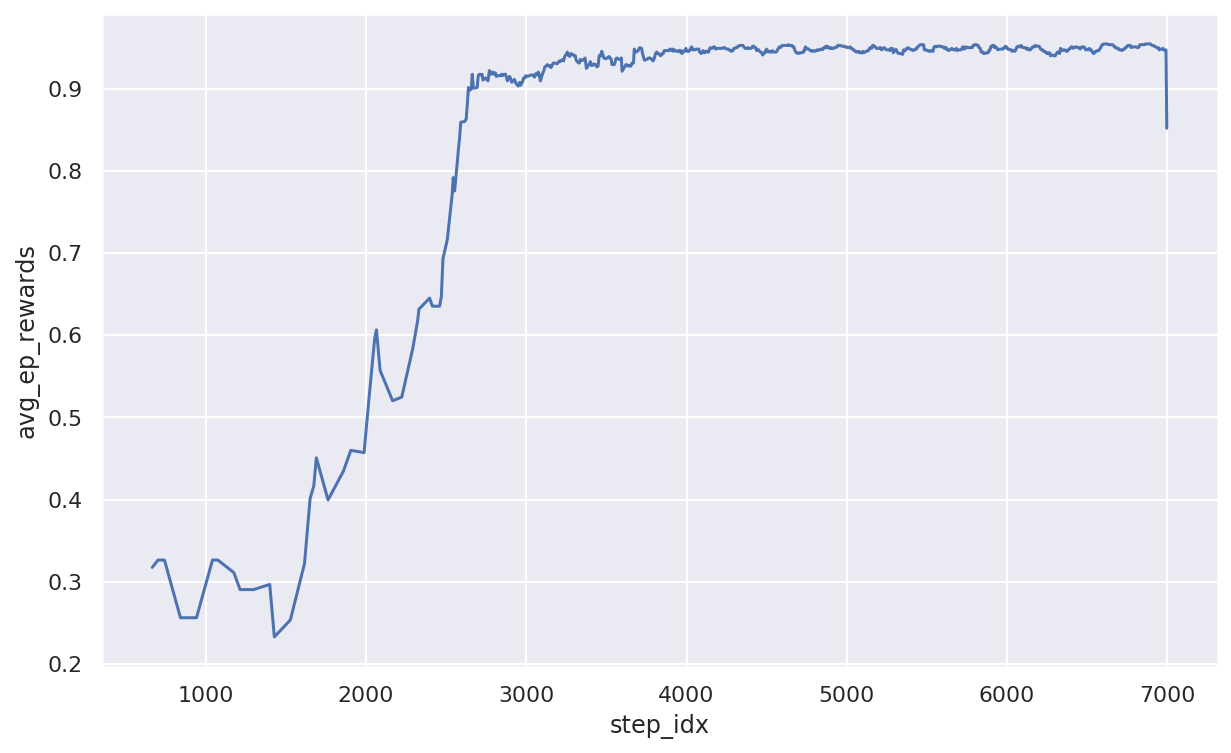

In [0]:
plot_stats(stats)

In [0]:
env_name = envs.maze
step_num = 50_000           # change the experiment length
seeds = [2, 5]              # add more maps
K = 2
stats = defaultdict(list)

common_seed = np.random.randint(1000)
for Agent in [DQN, DoubleDQN, DuelingDQN]:
    # maybe 621? :))
    reset_rng(526)  # we want each experiment to have the same starting conditions

    env = gym.make(env_name)
    env = TorchWrapper(FrameStack(ImgObsWrapper(ReseedWrapper(env, seeds=seeds)), k=K))
    net = get_estimator(env.action_space.n, input_ch=K*3, lin_size=64)
    
    agent_name = Agent.__name__
    print(f"\n{agent_name} started training.")
    stats_ = train(
        Agent(
            net,
            ReplayMemory(size=10_000, batch_size=32),
            O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
            get_epsilon_schedule(start=1.0, end=0.1, steps=10_000),
            env.action_space.n,
            warmup_steps=1000,
            update_steps=2,
            update_target_steps=256
        ),
        env,
        step_num=step_num
    )

    for k, v in stats_.items():
        stats[k] += v

Setting all rngs to seed=526

DQN started training.
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3563], R/ep=  0.00, steps/ep=324.
[ 20][  6668], R/ep=  0.05, steps/ep=310.
[ 30][  9908], R/ep=  0.00, steps/ep=324.
[ 40][ 13148], R/ep=  0.00, steps/ep=324.
[ 50][ 15863], R/ep=  0.17, steps/ep=272.
[ 60][ 18829], R/ep=  0.10, steps/ep=297.
[ 70][ 22006], R/ep=  0.03, steps/ep=318.
[ 80][ 25246], R/ep=  0.00, steps/ep=324.
[ 90][ 28486], R/ep=  0.00, steps/ep=324.
[100][ 31726], R/ep=  0.00, steps/ep=324.
[110][ 34966], R/ep=  0.00, steps/ep=324.
[120][ 38206], R/ep=  0.00, steps/ep=324.
[130][ 41446], R/ep=  0.00, steps/ep=324.
[140][ 44686], R/ep=  0.00, steps/ep=324.
[150][ 47926], R/ep=  0.00, steps/ep=324.
[157][ 49999], R/ep=  0.00, steps/ep=304.
Setting all rngs to seed=526

DoubleDQN started training.
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3501], R/ep=  0.04, steps/ep=318.
[ 20][  6741], R/ep=  0.00, steps/ep=324.
[ 30][  9735], R/ep=  0.09, steps/ep=299.
[ 40][ 1